Preperation to run a virtualenvironment for syllables:
* This is not perfect, but works as long as we don't have included these libraries into our standard VMs.

In [1]:
import numpy
import matplotlib.pyplot as plt
import seaborn as sns
import pandas
from collections import Counter


from fetch import fetch_dataframe
from lib.llama_files import inquire_llama

try:
    import spacy
    import pyphen
    from tqdm import tqdm
    from ipywidgets import interact
    import ipywidgets as widgets
    from parallel_pandas import ParallelPandas

except (ImportError, ModuleNotFoundError):
    !sudo apt-get install python3-ipywidgets --yes
    !sudo apt-get install pip --yes
    !sudo apt-get remove python3-tqdm --yes
    !sudo pip install --break-system-packages  spacy pyphen
    !sudo python3 -m spacy download en_core_web_sm --break-system-packages
    !sudo python3 -m spacy download de_core_news_sm --break-system-packages 
    !sudo pip install --upgrade parallel-pandas --break-system-packages 

    import spacy
    import pyphen
    from ipywidgets import interact
    import ipywidgets as widgets
    from parallel_pandas import ParallelPandas
    from tqdm import tqdm
    # from spacy import displacy

tqdm.pandas()
ParallelPandas.initialize(n_cpu=16, split_factor=4, disable_pr_bar=False)

dic = pyphen.Pyphen(lang="de_DE")


def num_of_syllables(text):
    return len(dic.positions(text)) + 1

## Define functions

In [2]:
def get_fre(text):
    """Der Lesbarkeitsindex *Flesch-Reading-Ease*, auch Flesch-Grad genannt, ist ein numerischer Wert für die Lesbarkeit,
       der aus einem Text berechnet werden kann. Je höher der Wert ist, desto leichter verständlich ist der Text.
       Gut verständliche Texte weisen einen Wert von etwa 60 bis 70 auf.

       [Flesch-Grad auf Wikepedia:Lesbarkeitsindex](https://de.wikipedia.org/wiki/Lesbarkeitsindex)

    # fre:
       Hier werden die Konstanten für den Deutschen Flesch-Grad verwendet.

    # fkgl:
       Flesch-Kincaid-Grade-Level
        Dieser Lesbarkeitsindex versucht, die Lesbarkeit auszudrücken in der Anzahl Schuljahre,
        die ein Leser absolviert haben muss, um den Text zu verstehen.
        Er ist auf die englische Sprache und das US-amerikanische Schulsystem abgestimmt.

    """
    text = text.replace("_", " ")
    num_words = len(text.split())
    num_syllables = num_of_syllables(text)
    num_sentences = 1
    if num_words == 0:
        return numpy.nan

    fre = (180 - (num_words / num_sentences)) - (58.5 * (num_syllables / num_words))
    fkgl = (0.39 * (num_words / num_sentences)) + (
        11.8 * (num_syllables / num_words) - 15.59
    )
    return {"fre": fre, "fkgl": fkgl}


def get_wstf(text):
    """Die Wiener Sachtextformel dient zur Berechnung der Lesbarkeit deutschsprachiger Texte.
    Sie gibt an, für welche Schulstufe ein Sachtext geeignet ist.
    Die Skala beginnt bei Schulstufe 4 und endet bei 15, wobei ab der Stufe 12 eher
    von Schwierigkeitsstufen als von Schulstufen gesprochen werden sollte.
    Ein Wert von 4 steht demnach für sehr leichten Text, dagegen bezeichnet 15 einen sehr schwierigen Text.

    [Wiener Sachtextformel auf Wikepedia:Lesbarkeitsindex](https://de.wikipedia.org/wiki/Lesbarkeitsindex)

    """
    text = text.replace(",", "")
    num_words = len(text.split())
    syl_per_word = numpy.array(list(map(num_of_syllables, text.split())))
    mean_long_words = numpy.sum(syl_per_word >= 3) / num_words * 100
    num_long_word = (
        numpy.sum(list(map(lambda x: len(x) > 6, text.split()))) / num_words * 100
    )
    num_short_words = numpy.sum(syl_per_word == 1) / num_words * 100
    if num_words == 0:
        return numpy.nan
    wstf1 = (
        0.1935 * mean_long_words
        + 0.1672 * num_words
        + 0.1297 * num_long_word
        - 0.0327 * num_short_words
        - 0.875
    )
    wstf2 = (
        0.2007 * mean_long_words + 0.1682 * num_words + 0.1373 * num_long_word - 2.779
    )
    wstf3 = 0.2963 * mean_long_words + 0.1905 * num_words - 1.1144
    wstf4 = 0.2744 * mean_long_words + 0.2656 * num_words - 1.693
    return {"wstf1": wstf1, "wstf2": wstf2, "wstf3": wstf3, "wstf4": wstf4}

### Read data from search index

In [3]:
data = fetch_dataframe(columns=["title", "description", "tags"])

### calculate reading indices

In [4]:
data["result_fre"] = data.title.p_apply(get_fre)
data["result_wstf"] = data.title.progress_apply(get_wstf)

GET_FRE DONE:   0%|          | 0/414971 [00:00<?, ?it/s]

100%|██████████| 414971/414971 [00:32<00:00, 12965.94it/s]


### remove NAs

In [5]:
to_remove = data.loc[data[["result_fre", "result_wstf"]].isna().any(axis=1)]
if not to_remove.empty:
    print("Removing the following dataset as no FRE or WSTF can be calculated")
    print(to_remove.index)
    data = data.drop(to_remove.index)

Removing the following dataset as no FRE or WSTF can be calculated
MultiIndex([('lu-bw', 'D02AF703C076A5EA5A187EF87DE9C451')],
           names=['source', 'id'])


### extract values from dictionary

In [6]:
data = data.join(pandas.json_normalize(data.result_wstf).set_index(data.index))
data = data.join(pandas.json_normalize(data.result_fre).set_index(data.index))

### sort and plot data

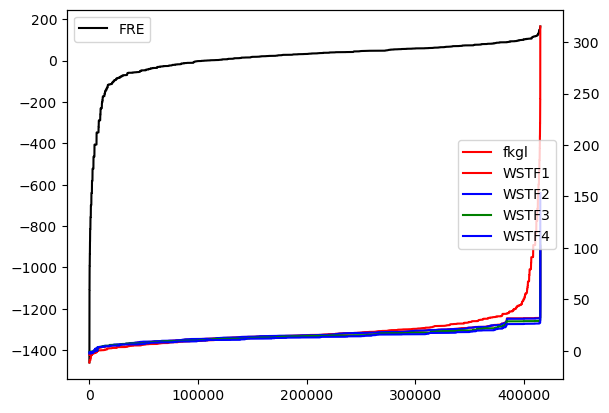

In [7]:
ax = plt.gca()
ax2 = ax.twinx()

data.fre.sort_values().reset_index(drop=True).plot(ax=ax, color="black", label="FRE")
data.fkgl.sort_values().reset_index(drop=True).plot(ax=ax2, color="red", label="fkgl")

data.wstf1.sort_values().reset_index(drop=True).plot(ax=ax2, color="r", label="WSTF1")
data.wstf2.sort_values().reset_index(drop=True).plot(ax=ax2, color="b", label="WSTF2")
data.wstf3.sort_values().reset_index(drop=True).plot(ax=ax2, color="g", label="WSTF3")
data.wstf4.sort_values().reset_index(drop=True).plot(
    ax=ax2, color="blue", label="WSTF4"
)

ax.legend(loc=2)
ax2.legend(loc=5)

## Calculate more statistical data about the title

In [8]:
data["words_in_title"] = data.title.str.split().map(len)
data["characters_in_title"] = data.title.replace(r"\s+", "", regex=True).map(len)
data["syllables_in_title"] = data.title.p_map(num_of_syllables)

MAP DONE:   0%|          | 0/64 [00:00<?, ?it/s]

In [9]:
# The function print_by_threshold is currently not working
def print_by_threshold(threshold, var="fre"):
    data_sorted = data.sort_values(by=var)
    value = data_sorted.loc[data_sorted[var] > threshold]
    if not value.empty:
        print(f"Next value after {var} = {threshold}:")
        print(value.iloc[0])


if False:
    interact(
        print_by_threshold,
        threshold=widgets.FloatSlider(value=0, min=-100, max=300, step=5.0),
        var=widgets.Dropdown(
            start="wstf1", options=data.filter(regex="wstf.+").columns
        ),
    )

# Beobachtungen:
* Viele Title haben negativen FRE, insbesondere solche die falsche Trennzeichen haben (Bindestrich statt Whitespace)
* Positives FRE macht noch keinen guten Titel
* Title von / aus PDFs müssen überarbeitet werden.
* Title aus Breadcrumb sollten anders getrennt werden
* Sehr lange Title (>40 Wörter) müssen überarbeitet werden

# Textanalyse mit NLP

In [10]:
nlp = spacy.load("de_core_news_sm")

text = data.sort_values(by="wstf1").title.iloc[-1]
# text = "Grundwassermessstelle 167655"
doc = nlp(text)
print(text)
print(
    "\t".join(
        ["text", "lemma_", "pos_", "tag_", "dep_", "shape_", "is_alpha", "is_stop"]
    )
)
tokenized = pandas.DataFrame(
    (
        map(
            repr,
            [
                token.text,
                token.lemma_,
                token.pos_,
                token.tag_,
                token.dep_,
                token.shape_,
                token.is_alpha,
                token.is_stop,
            ],
        )
        for token in doc
    ),
    columns=["text", "lemma_", "pos_", "tag_", "dep_", "shape_", "is_alpha", "is_stop"],
)
tokenized

Chronik der UIS-Entwicklung digital@bw – Teilstrategie Umwelt Stärkung der Umweltverwaltung Naturschutz und UIS FLIWAS - Zeitgemäße Hochwasserabwehr WIBAS wird zentral Neue Rahmenkonzeption als Grundlage der UIS-Entwicklung Gut informiert bei Hochwasser Neues aus dem UIS-Labor Umweltverwaltungsgesetz bekräftigt Teilhabe der Bürgerschaft LUBW – 40 Jahre aktiv für Natur und Umwelt IT-Neuordnung des Landes Einsatz für Ressourcenschonung: Kompetenzstelle Green IT am UM Energieatlas Baden-Württemberg Umweltportal mit neuer Technik Green IT-Landesstrategie 2020 Umweltmeldungen per App Dem Müll auf der Spur im Themenpark Umwelt Von MAF-UIS zu INOVUM Potenzialatlas Erneuerbare Energien App Meine Umwelt Konzeption Web-UIS 3.0 30 Jahre Medienübergreifende Umweltbeobachtung Upgrade des Open Data Portals der LUBW (UDO) Staatlich-Kommunaler Datenverbund Strategie UIS Mobil Kooperation Landesumweltportale Umweltdaten 2012 Windpotenziale erkennen Effizientes Krisenmanagement Internetplattform für bet

text               lemma_     pos_    tag_     dep_  \
0              'Chronik'            'Chronik'   'NOUN'    'NN'   'ROOT'   
1                  'der'                'der'    'DET'   'ART'     'nk'   
2      'UIS-Entwicklung'    'UIS-Entwicklung'   'NOUN'    'NN'     'ag'   
3           'digital@bw'         'digital@bw'  'PROPN'    'NE'     'nk'   
4                    '–'                 '--'  'PUNCT'    '$('  'punct'   
..                   ...                  ...      ...     ...      ...   
553  'Grunddatenkatalog'  'Grunddatenkatalog'  'PROPN'    'NE'    'pnc'   
554            'Signale'             'Signal'   'NOUN'    'NN'     'nk'   
555                'aus'                'aus'    'ADP'  'APPR'    'mnr'   
556                'der'                'der'    'DET'   'ART'     'nk'   
557              'Natur'              'Natur'   'NOUN'    'NN'     'nk'   

          shape_ is_alpha is_stop  
0        'Xxxxx'     True   False  
1          'xxx'     True    True  
2    'XXX-Xxxxx'    False   False  
3      'xxxx@xx'    False   False  
4            '–'    False   False  
..           ...      ...     ...  
553      'Xxxxx'     True   False  
554      'Xxxxx'     True   False  
555        'xxx'     True    True  
556        'xxx'     True    True  
557      'Xxxxx'     True   False  

[558 rows x 8 columns]

# Anzahl von Umthes Tags im Titel

In [11]:
data["num_tags"] = data.tags.dropna().map(len)
data["UMTHES"] = data.tags.progress_apply(
    lambda tag: [
        tag_dict.get("Umthes", {"label": ""}).get("label", "") for tag_dict in tag
    ]
    if isinstance(tag, list)
    else []
)

tags = data[["num_tags", "tags", "title"]].explode(column="tags")
tags_index = tags.index

tags = (
    tags.reset_index(drop=True)
    .join(pandas.json_normalize(tags.tags, sep="_"))
    .set_index(tags_index)
)

100%|██████████| 414970/414970 [00:01<00:00, 297257.68it/s]


Check if any title actually contains an Umthes label:

In [12]:
tags["umthes_contained_in_title"] = tags.fillna("").progress_apply(
    lambda row: row.Umthes_label in row.title, axis=1
)
num_tags = pandas.pivot_table(
    tags, values="umthes_contained_in_title", index=["source", "id"], aggfunc="sum"
)
data = data.merge(num_tags, left_index=True, right_index=True)

data["umthes_ratio_title"] = data.umthes_contained_in_title / data.words_in_title

100%|██████████| 3208378/3208378 [00:38<00:00, 83912.39it/s]


# Uniqueness vom Titel

In [13]:
title_wordcount = Counter()
data.title.str.split().map(lambda wordlist: title_wordcount.update(wordlist))

source              id                                                                                                                          
uvp-verbund-hb      6A2D429A-5682-4E67-AB90-462A8D90ED0F                                                                                            None
thru-de-uba         plant-details-2022-299704                                                                                                       None
aktion-flaeche-uba  https---aktion-flaeche-de-was-waere-wenn-studie-ermittelt-das-wohnbaupoenzial-durch-einhaltung-regionalplanerischer-vorgaben    None
thru-de-uba         plant-details-2022-298498                                                                                                       None
wisia-bfn           32241                                                                                                                           None
                                                                                          

In [14]:
title_wordcount_lemma = Counter()


def get_stemmed_word_list(text):
    doc = nlp(text)
    return [word.lemma_ for word in doc if not word.is_stop]


# def get_stemmed_number(wordlist):
#     return [title_wordcount_lemma.get(word, 0) for word in wordlist]


def title_exoticness_with_stemming(wordlist):
    numbers = numpy.array([title_wordcount_lemma.get(word, 0) for word in wordlist])
    if len(numbers) > 0:
        # This function was created to indicate how rare a given word is within the title set
        # ranging from 0 (very common) to 1 (very rare)
        return sum(numbers * numbers) / (sum(numbers) * sum(numbers))
    else:
        return numpy.nan


if True:
    stemmed_words = data.title.p_apply(get_stemmed_word_list)
    stemmed_words.progress_apply(title_wordcount_lemma.update)


def title_exoticness(title):
    numbers = numpy.array([title_wordcount.get(word) for word in title.split()])
    return sum(numbers * numbers) / (sum(numbers) * sum(numbers))

GET_STEMMED_WORD_LIST DONE:   0%|          | 0/414970 [00:00<?, ?it/s]

100%|██████████| 414970/414970 [00:01<00:00, 354801.50it/s]


In [16]:
data["title_exoticness_lemma"] = stemmed_words.progress_apply(
    title_exoticness_with_stemming
)
data["title_exoticness"] = data.title.progress_apply(title_exoticness)
data.sort_values(by="title_exoticness")[
    ["title", "title_exoticness", "title_exoticness_lemma"]
]

  0%|          | 0/414970 [00:00<?, ?it/s]

100%|██████████| 414970/414970 [00:03<00:00, 108149.96it/s]


title  \
source     id                                                                                                      
lu-bw      987D2441A31E1100C77FF1BDC9336EC0                    Chronik der UIS-Entwicklung digital@bw – Teils...   
suche-st   LAU-boden-wasser-abfall-abwasser-selbstueberwac...  Informationen zur Selbstüberwachungsverordnung...   
lu-bw      D5EC5ACC22600B95501847CFF044697F                    Komponenten März Februar Oktober September Jul...   
suche-st   LENA-lena-publikationen-c166148                     Publikationen der LENA Unsere Angebote für Ene...   
           LENA-lena-presse-pressearchiv-2014                  Pressemitteilungen 2014 LENA hat den Energieat...   
...                                                                                                          ...   
probas-uba 7ae2ff94-245c-42ef-a191-eaea77f52f8f                                        Raffinerie\Benzin-DE-2005   
lu-bw      D2DEF0AC4E5F5CC0B5A5334E5D129FB5                                     col_grabil_Abgabe_2018_TK25Q.pdf   
probas-uba 7736f827-d822-40ab-afe7-5fc11ae0e090                               Konfektion-CN\Baumwolle-US-II-2000   
           d6d6c35b-37be-49b7-a08f-3b0a6f4031ba                                          NG-Handel\EU-Milch-2030   
suche-st   LAU-fileadmin-Bibliothek-Politik_und_Verwaltung...                                          Amtsblatt   

                                                               title_exoticness  \
source     id                                                                     
lu-bw      987D2441A31E1100C77FF1BDC9336EC0                            0.014991   
suche-st   LAU-boden-wasser-abfall-abwasser-selbstueberwac...          0.019844   
lu-bw      D5EC5ACC22600B95501847CFF044697F                            0.020718   
suche-st   LENA-lena-publikationen-c166148                             0.021534   
           LENA-lena-presse-pressearchiv-2014                          0.023478   
...                                                                         ...   
probas-uba 7ae2ff94-245c-42ef-a191-eaea77f52f8f                        1.000000   
lu-bw      D2DEF0AC4E5F5CC0B5A5334E5D129FB5                            1.000000   
probas-uba 7736f827-d822-40ab-afe7-5fc11ae0e090                        1.000000   
           d6d6c35b-37be-49b7-a08f-3b0a6f4031ba                        1.000000   
suche-st   LAU-fileadmin-Bibliothek-Politik_und_Verwaltung...          1.000000   

                                                               title_exoticness_lemma  
source     id                                                                          
lu-bw      987D2441A31E1100C77FF1BDC9336EC0                                  0.033040  
suche-st   LAU-boden-wasser-abfall-abwasser-selbstueberwac...                0.029324  
lu-bw      D5EC5ACC22600B95501847CFF044697F                                  0.020731  
suche-st   LENA-lena-publikationen-c166148                                   0.016890  
           LENA-lena-presse-pressearchiv-2014                                0.017408  
...                                                                               ...  
probas-uba 7ae2ff94-245c-42ef-a191-eaea77f52f8f                              1.000000  
lu-bw      D2DEF0AC4E5F5CC0B5A5334E5D129FB5                                  1.000000  
probas-uba 7736f827-d822-40ab-afe7-5fc11ae0e090                              1.000000  
           d6d6c35b-37be-49b7-a08f-3b0a6f4031ba                              1.000000  
suche-st   LAU-fileadmin-Bibliothek-Politik_und_Verwaltung...                1.000000  

[414970 rows x 3 columns]

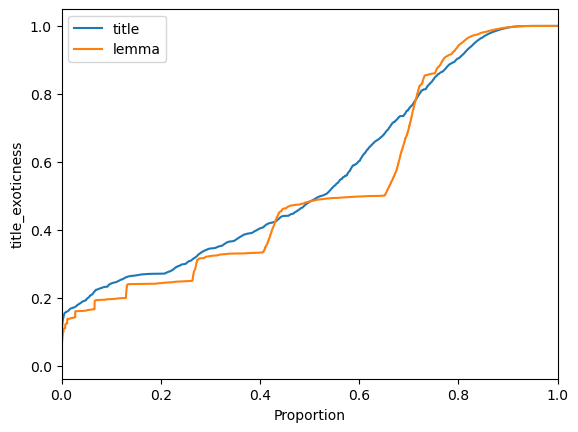

In [17]:
ax = plt.gca()
a = sns.ecdfplot(y="title_exoticness", data=data, ax=ax, label="title")
b = sns.ecdfplot(y="title_exoticness_lemma", data=data, ax=ax, label="lemma")
plt.legend()

In [19]:
# The server for llama needs be started first to execute this (see llama_files.py)
selection = data.groupby(pandas.cut(data.title_exoticness, bins=5)).sample(5)
selection = selection.join(
    pandas.json_normalize(selection.title.progress_apply(inquire_llama)).set_index(
        selection.index
    )
)

/tmp/ipykernel_15850/959147409.py:2: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  selection = data.groupby(pandas.cut(data.title_exoticness, bins=5)).sample(5)
100%|██████████| 25/25 [07:04<00:00, 16.97s/it]


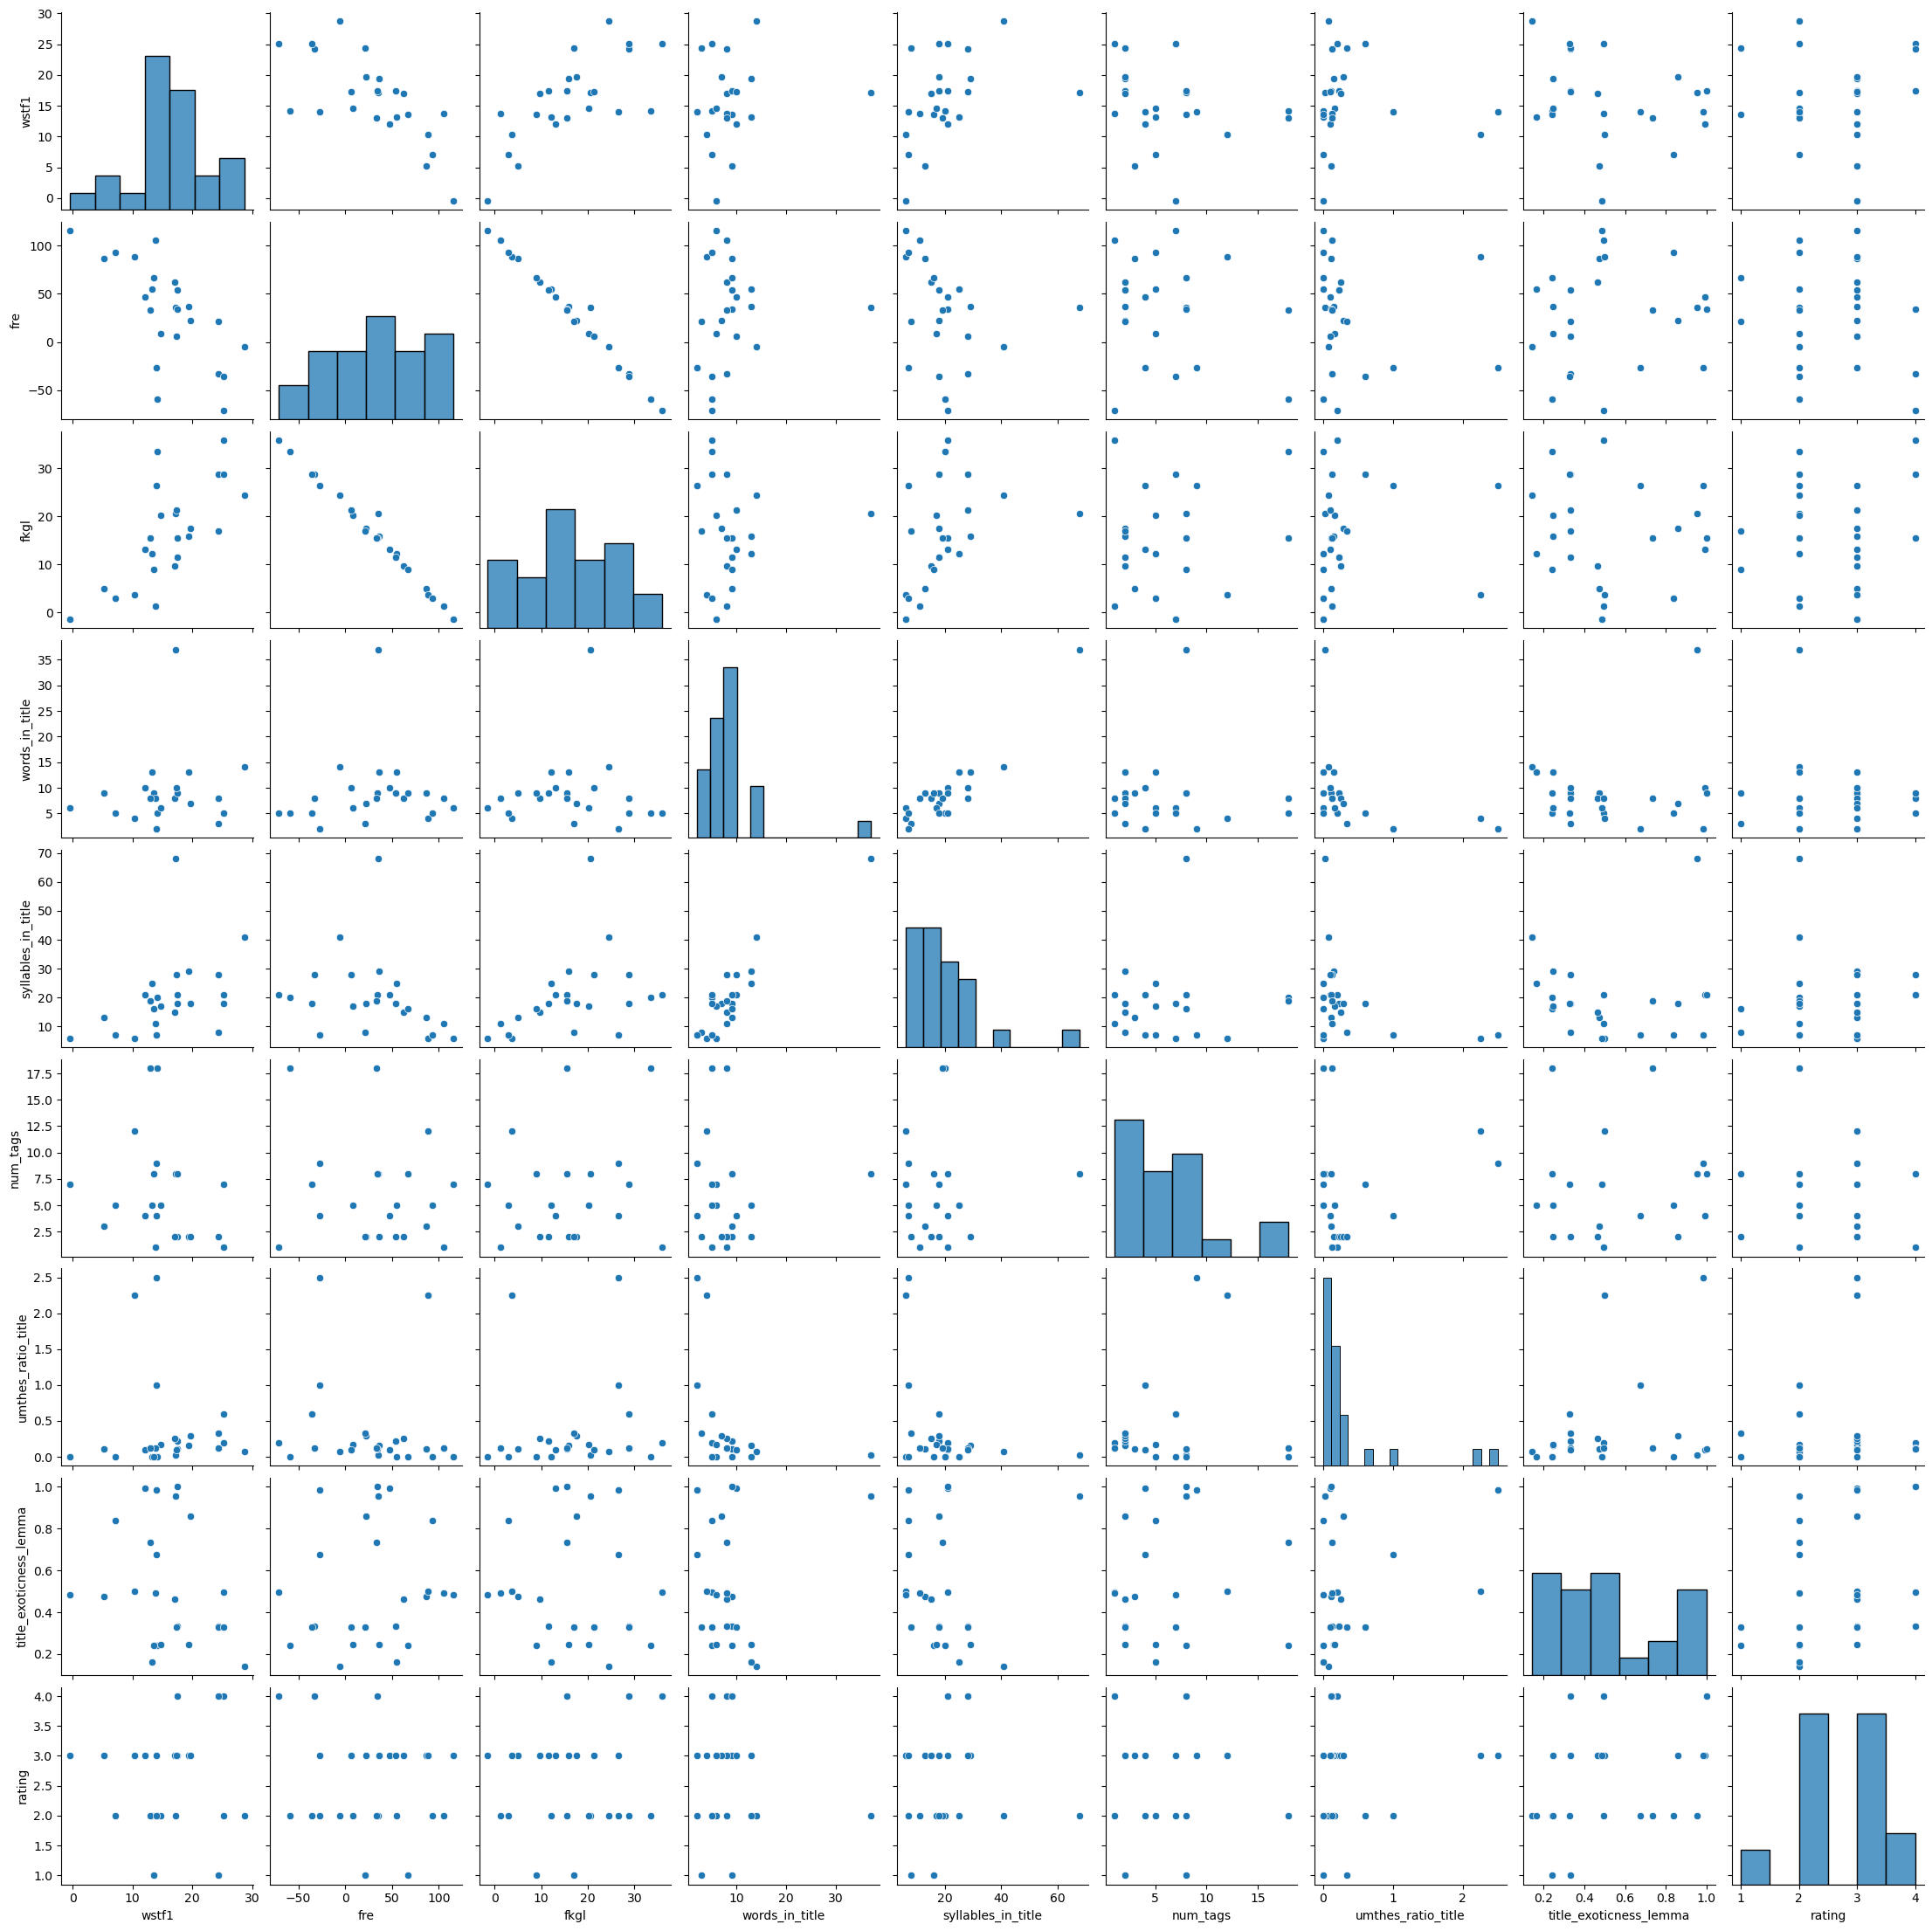

In [20]:
sns.pairplot(
    selection[
        [
            "wstf1",
            "fre",
            "fkgl",
            "words_in_title",
            "syllables_in_title",
            "num_tags",
            "umthes_ratio_title",
            "title_exoticness_lemma",
            "rating",
        ]
    ]
)